## 1. Import

In [1]:
import os
import sys
if os.getcwd().endswith('notebooks'):
    os.chdir('..')
sys.path.insert(0, os.getcwd())
print(f"Aktuelles Arbeitsverzeichnis: {os.getcwd()}")

Aktuelles Arbeitsverzeichnis: c:\Users\hp\OneDrive\Desktop\DBU\wai81-ai-theory\ml_picture_recognition


In [2]:
# 1. Bibliotheken importieren
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from utils.model import HockeyActionModel   # Modell aus model.py
from utils.dataloader import HockeyDataset  # DataLoader aus dataloader.py
import os 
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

## 2. Device & Hyperparameter


In [3]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


True
NVIDIA RTX A5000 Laptop GPU


In [4]:
# 2. Device auswählen
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Benutze Gerät: {device}")

Benutze Gerät: cuda


In [5]:
# Konfiguration
batch_size = 4
num_epochs = 30
frames_per_clip = 100

## 3. Dataset & Dataloader

In [6]:
# Trainings-Transform mit Augmentation (nur fürs Training)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),            # zufälliges Spiegeln
    transforms.RandomRotation(degrees=5),         # leichte Drehung
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Farbabweichung
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Val-Transform ohne Augmentation
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Datensätze direkt aus fixen CSV-Dateien laden (zuvor erzeugt)
train_dataset = HockeyDataset('data/labels_train.csv', 'data/train_frames', transform=train_transform, frames_per_clip=frames_per_clip)
val_dataset   = HockeyDataset('data/labels_val.csv', 'data/train_frames', transform=val_transform, frames_per_clip=frames_per_clip)

# Dataloader für Training und Validierung
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


## 4. Model + Loss + Optimizer 

In [7]:
model = HockeyActionModel().to(device)                      # Modell auf GPU/CPU laden
criterion = criterion = nn.BCEWithLogitsLoss()              # Verlustfunktion
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Optimierer

# Lernraten-Scheduler: reduziert LR, wenn val_loss stagniert
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)


c:\Users\hp\anaconda3\envs\picture\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\hp\anaconda3\envs\picture\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\hp\anaconda3\envs\picture\lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


## 5. Trainingsloop

In [8]:
# Container für Trainings- und Validierungsverluste und F1-Scores
train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

In [ ]:
best_val_f1 = 0
early_stopping_counter = 0
patience = 5  # für Early Stopping

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_preds, all_targets = [], []

    for frames, labels in train_loader:
        frames = frames.to(device)                     # Shape: [B, T, 3, 224, 224]
        labels = labels.float().to(device)             # Multi-Label: [B, 4]

        outputs = model(frames)                        # Output: [B, 4]
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        all_preds.append((torch.sigmoid(outputs) > 0.5).cpu())
        all_targets.append(labels.cpu())

    train_loss = running_loss / len(train_loader)
    train_f1 = f1_score(torch.cat(all_targets), torch.cat(all_preds), average="macro", zero_division=0)

    # speichern
    train_losses.append(train_loss)
    train_f1_scores.append(train_f1)

    # Validierung
    model.eval()
    val_loss = 0.0
    val_preds, val_targets = [], []

    with torch.no_grad():
        for frames, labels in val_loader:
            frames = frames.to(device)
            labels = labels.float().to(device)

            outputs = model(frames)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_preds.append((torch.sigmoid(outputs) > 0.5).cpu())
            val_targets.append(labels.cpu())

    val_loss /= len(val_loader)
    val_f1 = f1_score(torch.cat(val_targets), torch.cat(val_preds), average="macro", zero_division=0)

    # speichern
    val_losses.append(val_loss)
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, F1 {train_f1:.2f} | Val Loss {val_loss:.4f}, F1 {val_f1:.2f}")

    # Early Stopping
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        early_stopping_counter = 0
        torch.save(model.state_dict(), "best_resnet18_lstm.pth")
    else:
        early_stopping_counter += 1
        print(f"Early Stopping Counter: {early_stopping_counter}/{patience}")
        if early_stopping_counter >= patience:
            print("⏹️ Early stopping triggered.")
            break

Epoch 1: Train Loss 0.5381, F1 0.35 | Val Loss 0.5173, F1 0.35
Epoch 2: Train Loss 0.4853, F1 0.42 | Val Loss 0.5379, F1 0.35
Early Stopping Counter: 1/5
Epoch 3: Train Loss 0.4253, F1 0.42 | Val Loss 0.4926, F1 0.50
Epoch 4: Train Loss 0.4565, F1 0.49 | Val Loss 0.5236, F1 0.25
Early Stopping Counter: 1/5
Epoch 5: Train Loss 0.4135, F1 0.48 | Val Loss 0.4833, F1 0.43
Early Stopping Counter: 2/5
Epoch 6: Train Loss 0.3790, F1 0.56 | Val Loss 0.5145, F1 0.39
Early Stopping Counter: 3/5
Epoch 7: Train Loss 0.3877, F1 0.54 | Val Loss 0.4990, F1 0.44
Early Stopping Counter: 4/5
Epoch 8: Train Loss 0.3803, F1 0.63 | Val Loss 0.5636, F1 0.37
Early Stopping Counter: 5/5
⏹️ Early stopping triggered.


## 6. Plot Training und Validation

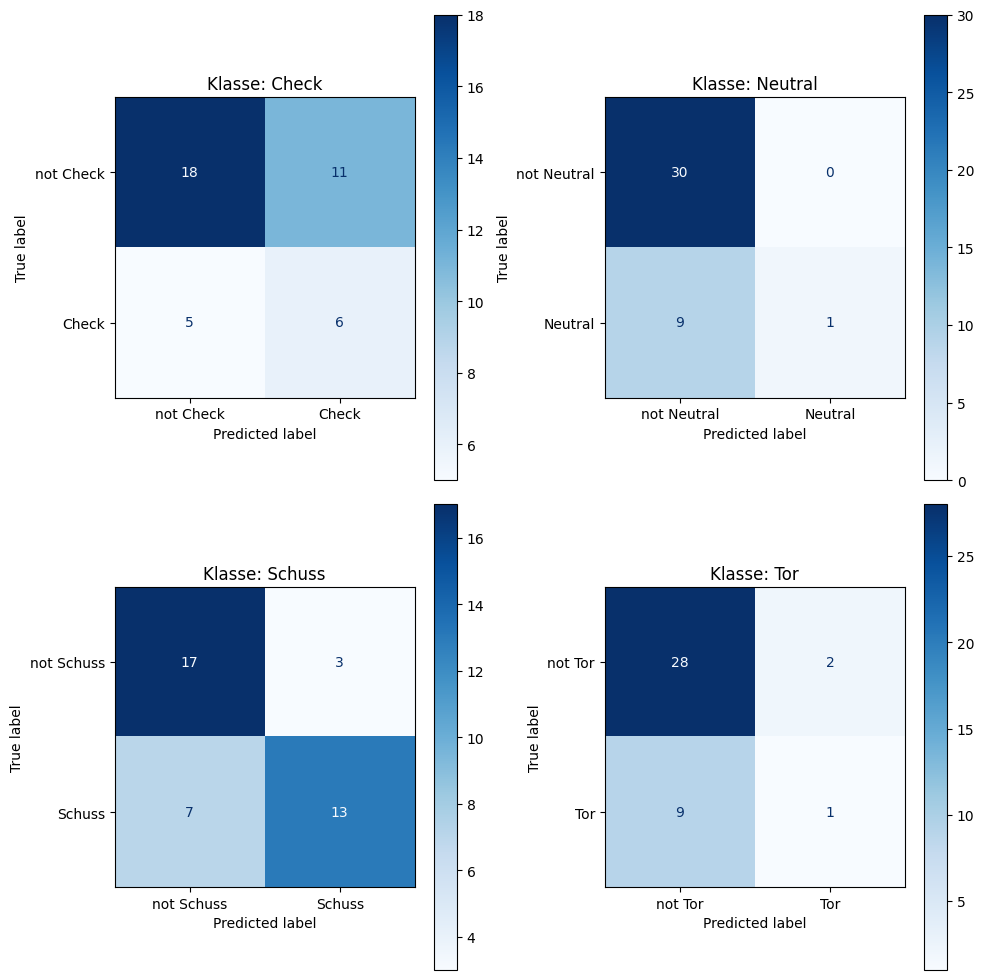

In [10]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
import numpy as np

# Klassen-Labels
class_names = ['Check', 'Neutral', 'Schuss', 'Tor']

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for frames, labels in val_loader:
        frames = frames.to(device)
        labels = labels.to(device)

        outputs = model(frames)
        predicted = (torch.sigmoid(outputs) > 0.5).int()

        all_preds.append(predicted.cpu())
        all_labels.append(labels.cpu().int())

# Tensors stapeln
all_preds = torch.cat(all_preds).numpy()  # Shape [N, 4]
all_labels = torch.cat(all_labels).numpy()

# Multilabel Confusion Matrix (eine 2x2-Matrix pro Klasse)
mcm = multilabel_confusion_matrix(all_labels, all_preds)

# Plot: jede Klasse einzeln anzeigen
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for i in range(len(class_names)):
    ConfusionMatrixDisplay(
        confusion_matrix=mcm[i],
        display_labels=[f'not {class_names[i]}', class_names[i]]
    ).plot(ax=axes[i], cmap='Blues', values_format='d')
    axes[i].set_title(f"Klasse: {class_names[i]}")

plt.tight_layout()
plt.show()


In [11]:
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds, target_names=class_names))


              precision    recall  f1-score   support

       Check       0.35      0.55      0.43        11
     Neutral       1.00      0.10      0.18        10
      Schuss       0.81      0.65      0.72        20
         Tor       0.33      0.10      0.15        10

   micro avg       0.57      0.41      0.48        51
   macro avg       0.62      0.35      0.37        51
weighted avg       0.66      0.41      0.44        51
 samples avg       0.50      0.40      0.43        51



c:\Users\hp\anaconda3\envs\picture\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


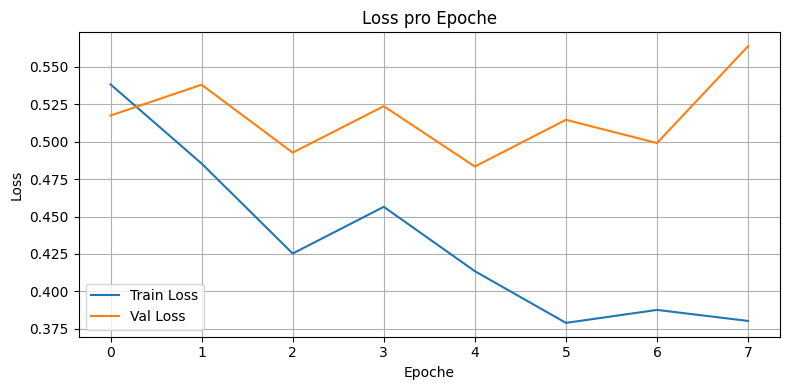

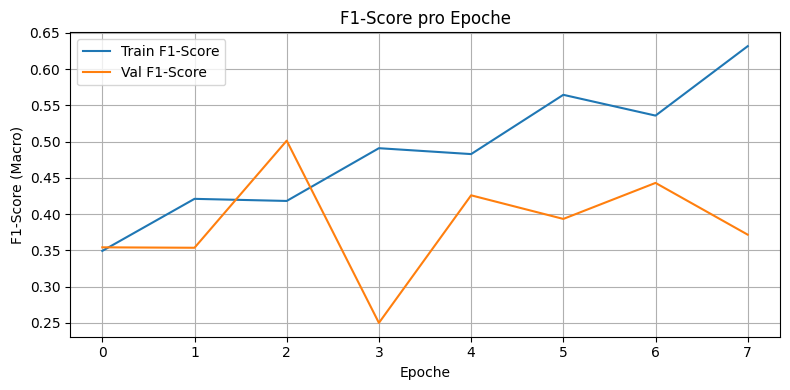

In [12]:
import matplotlib.pyplot as plt

# Loss-Verlauf
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.title('Loss pro Epoche')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# F1-Verlauf (statt Accuracy)
plt.figure(figsize=(8, 4))
plt.plot(train_f1_scores, label='Train F1-Score')
plt.plot(val_f1_scores, label='Val F1-Score')
plt.xlabel('Epoche')
plt.ylabel('F1-Score (Macro)')
plt.title('F1-Score pro Epoche')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 6. Modell speichern

In [17]:
os.makedirs('models', exist_ok=True)
torch.save(model.state_dict(), 'models/best_resnet18_lstm.pth')
print("✅ Modell erfolgreich gespeichert.")


✅ Modell erfolgreich gespeichert.
